<a href="https://colab.research.google.com/github/SourLemon23/covid19-diagnosis/blob/master/COVID_19_CT_Diagnosis_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # Grad-CAM
# ! pip install keras==2.2.0
# ! pip install tensorflow==1.10.0
# ! pip install keras==2.2.2 # EfficientNet PyPi
# ! pip install tensorflow==1.12.0 # EfficientNet PyPi

# Versions that are compatible with vis
# ! pip install keras==2.2.4
# ! pip install tensorflow==1.14.0
# ! pip install keras_applications >= 1.0.7
# https://stackoverflow.com/questions/57773636/no-attribute-set-keras-submodules

# ! pip install vis
# ! pip install scipy==1.1.0

In [2]:
import os
import numpy as np
import random

import tensorflow as tf
try:
    %tensorflow_version 2.x
except:
    pass

print('Using TensorFlow Version:', tf.__version__)

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt

# EfficientNetB7
! pip install -U efficientnet
from efficientnet.tfkeras import EfficientNetB7
# from keras.applications.inception_v3 import preprocess_input

import scipy
print('Using SciPy Version:', scipy.__version__) # Should be 1.1.0

Using TensorFlow Version: 2.3.0
     |████████████████████████████████| 51kB 5.8MB/s 
Using SciPy Version: 1.4.1


In [3]:
# ! pip install git+git://github.com/raghakot/keras-vis.git --upgrade --no-deps
# import vis

# from vis.utils import utils
# from vis.visualization import visualize_cam

# --------------------------------------------
# FROM https://github.com/raghakot/keras-vis/blob/master/applications/self_driving/visualize_attention.ipynb
# --------------------------------------------
# for i, modifier in enumerate(modifiers):
#     heatmap = visualize_cam(model, layer_idx=-1, filter_indices=0, 
#                             seed_input=bgr_img, grad_modifier=modifier)
#     plt.figure()
#     plt.title(titles[i])
#     # Overlay is used to alpha blend heatmap onto img.
#     jet_heatmap = np.uint8(cm.jet(heatmap)[..., :3] * 255)
#     plt.imshow(overlay(img, jet_heatmap, alpha=0.7))

In [4]:
# Make sure hardware accelerator is set to "GPU"
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
# Authorize access to mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Initialize dataset directories (Google Drive)
# ct_training_dir   = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset/Training'
# ct_validation_dir = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset/Validation'
# ct_testing_dir    = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset/Testing'

ct_training_dir   = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset V4/Training'
ct_validation_dir = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset V4/Validation'
ct_testing_dir    = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset V4/Testing'

In [7]:
# # Store all testing images in a randomized list
# testing_img_paths = []

# for root, dirs, files in os.walk(testing_dir):
#     for filename in files:
#         testing_img_paths.append(os.path.abspath(os.path.join(root, filename)))

# # Randomize the list
# random.shuffle(testing_img_paths)

In [8]:
# Initialize constants

# ---------------------------------------------------------
# Make sure to make these all CAPS
# ---------------------------------------------------------
classes = ['COVID-19 Positive', 'COVID-19 Negative']
img_width, img_height = 150, 150
target_size = (img_width, img_height)
input_shape = (img_width, img_height, 3)

testing_set_start_index = -50
testing_set_end_index = 49

batch_size = 30
epochs = 1
dropout_rate = 0.2
metrics = [# BinaryAccuracy(name='binary_accuracy'),
           'accuracy',
           Precision(name='precision'),
           Recall(name='recall')]

In [9]:
# Augment data
training_data_gen = ImageDataGenerator(rescale=1./255,
                                       featurewise_center=False, # Set input mean to 0 over dataset
                                       samplewise_center=False, # Set each sample mean to 0
                                       featurewise_std_normalization=False, # Divide inputs by std of dataset
                                       samplewise_std_normalization=False, # Divide each input by its std
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       zoom_range=0.15,
                                       shear_range=0.15,
                                       rotation_range=360,
                                       width_shift_range=0.15,
                                       height_shift_range=0.15,
                                       validation_split=0.15)

validation_data_gen = ImageDataGenerator(rescale=1./255)

testing_data_gen = ImageDataGenerator(rescale=1./255)

In [10]:
# Split data
training_generator = training_data_gen.flow_from_directory(ct_training_dir,
                                                           target_size=target_size,
                                                           class_mode='binary',
                                                           batch_size=batch_size,
                                                           shuffle=True)

#  SHUFFLE = TRUE??
validation_generator = validation_data_gen.flow_from_directory(ct_validation_dir,
                                                               target_size=target_size,
                                                               class_mode='binary',
                                                               batch_size=batch_size,
                                                               shuffle=False)

testing_generator = testing_data_gen.flow_from_directory(ct_testing_dir,
                                                         target_size = target_size,
                                                         class_mode='binary',
                                                         batch_size=batch_size,
                                                         shuffle=True)

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


In [11]:
# from tensorflow.keras.layers.experimental import preprocessing


# def build_model(num_classes):
#     inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
#     x = img_augmentation(inputs)
#     model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

#     # Freeze the pretrained weights
#     model.trainable = False

#     # Rebuild top
#     x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
#     x = layers.BatchNormalization()(x)

#     top_dropout_rate = 0.2
#     x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
#     outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

#     # Compile
#     model = tf.keras.Model(inputs, outputs, name="EfficientNet")
#     optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
#     model.compile(
#         optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
#     )
#     return model

In [12]:
# def conv_block(x, filters):
#     x = Conv2D(filters, (3, 3), activation = 'relu', padding='same', input_shape=input_shape)(x)
#     x = BatchNormalization()(x)
#     x = MaxPooling2D(pool_size=(2, 2), padding='same')(x) # Max pooling picks up more prominent, sharp features than average pooling
#     x = Dropout(dropout_rate)(x)

In [13]:
# def dense_block(x, units):
#     x = Dense(units, activation="relu")(x)
#     x = BatchNormalization()(x)
#     x = Dropout(dropout_rate)(x)

In [14]:
# base_model = EfficientNetB7(weights='imagenet',
#                                 include_top=True)

# base_model.summary()

In [15]:
# Create a neural network
def create_model():
    # Instantiate a base model with pre-trained weights
    base_model = EfficientNetB7(weights='imagenet',
                                include_top=False,
                                input_shape=input_shape)
    x = base_model.output

    # Add new classifier layers to end of base_model
    x = BatchNormalization()(x)
    # x = GlobalMaxPooling2D()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(2560, activation="relu")(x)
    x = Dense(2560, activation="relu")(x)

    # A Dense classifier with a single unit (binary classification)
    predictions = Dense(1, activation="sigmoid")(x)

    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    model = Model(inputs=base_model.inputs, outputs=predictions)

    # model = Sequential()
    # model.add(base_model)
    # model.add(GlobalAveragePooling2D)
    # model.add(Conv2D(16, (3, 3), activation = 'relu', padding='same', input_shape=input_shape))
    # model.add(BatchNormalization())
    # model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    # model.add(Dropout(dropout_rate))

    # model.add(Conv2D(32, (3, 3), activation = 'relu', padding='same'))
    # model.add(BatchNormalization())
    # model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    # model.add(Dropout(dropout_rate))

    # model.add(Dense(32, activation="relu"))
    # model.add(BatchNormalization())
    # model.add(Dropout(dropout_rate))

    # model.add(Dense(16, activation="relu"))
    # model.add(BatchNormalization())
    # model.add(Dropout(dropout_rate))

    # model.add(Flatten())
    # model.add(Dense(1, activation="sigmoid"))

    return model

In [16]:
# Print a summary of the network architecture
def print_model_summary(model):
    model.summary()

In [17]:
# Configure model
def compile_model(model):
    model.compile(loss='binary_crossentropy',
                  optimizer='adam', # tf.keras.optimizers.RMSprop(lr=1e-4)
                  metrics=metrics)

In [18]:
# Train the model
def fit_model(model):
    # Early Stopping Implementation from: https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_03_4_early_stop.ipynb
    # Early Stopping Documentation: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    # es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    #                                           min_delta=1e-3,
    #                                           patience=3,
    #                                           verbose=1,
    #                                           mode='auto')

    history = model.fit(training_generator,
                        epochs=epochs,
                        steps_per_epoch=(training_generator.n/batch_size),
                        validation_data=validation_generator,
                        validation_steps=(validation_generator.n/batch_size))
                        # callbacks=[es_callback])
    
    return history

In [19]:
# Visualize metrics with graphs
def evaluate_model(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    prc = history.history['precision']
    val_prc = history.history['val_precision']

    rec = history.history['recall']
    val_rec = history.history['val_recall']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, prc, label='Training Precision')
    plt.plot(epochs_range, val_prc, label='Validation Precision')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Precision')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, rec, label='Training Recall')
    plt.plot(epochs_range, val_rec, label='Validation Recall')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Recall')

In [20]:
# Randomly pick and display an unseen image for the network to predict
def select_testing_image():
    image_num = random.randint(testing_set_start_index, testing_set_end_index)
    testing_img = testing_generator[0][0][image_num]

    class_num = np.argmax(testing_generator[0][1][image_num])
    true_label = classes[class_num].capitalize()

    print(f'True Label: {true_label}')

    return testing_img

In [21]:
# Run a diagnosis to determine if the patient is COVID-19 positive or negative
def run_diagnosis(model, testing_img):      
    img_array = img_to_array(testing_img)
    img_array = img_array.reshape(-1, img_width, img_height, 3)

    predictions = model.predict(img_array)
    class_num = predictions.argmax()

    network_percent_confidence = str(np.max(predictions) * 100)[:4] + '% match'
    network_prediction = classes[class_num].capitalize()

    font = {'family': 'DejaVu Sans',
            'color' : 'red',
            'weight': 'heavy',
            'size'  :  10}
    
    plt.imshow(testing_img)
    # Find a way to only make the text after "Network Prediction" red
    plt.title(f'Network Prediction: {network_prediction} ({network_percent_confidence})', fontdict=font) 

In [22]:
model = create_model()
compile_model(model)
print_model_summary(model)

258441216/258434480 [==============================] - 20s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 75, 75, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 75, 75, 64)   256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 75, 75, 64)   0           stem_bn[0][0]                    
___________________

In [23]:
history = fit_model(model)

534/533 [==============================] - 16695s 31s/step - loss: 0.3501 - accuracy: 0.8459 - precision: 0.8560 - recall: 0.8317 - val_loss: 0.1799 - val_accuracy: 0.9513 - val_precision: 0.9788 - val_recall: 0.9225


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


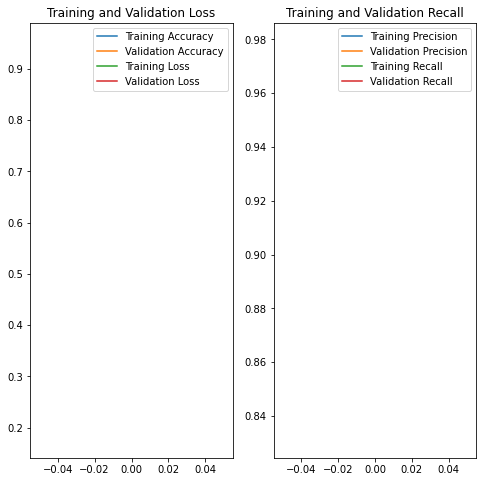

In [24]:
evaluate_model(history)

In [25]:
# Prints labels (alphabetical)
training_generator.class_indices

{'covid19': 0, 'normal': 1}

In [26]:
# classifier_layer_names = ['top_conv', 'top_bn', 'top_activation', 'global_average_pooling2d_1', 'dropout_1', 'dense_3', 'dense_4', 'dense_5']
# last_conv_layer_name = 'block7d_add'

def convert_to_img_array(img_path):
    # img is a PIL image
    img = load_img(img_path,
                   target_size=target_size)
    
    # Convert to float32 Numpy array
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    # img_array = img_array.reshape((-1, img_width, img_height, 3))

    # We add a dimension to transform our array into a "batch"
    # img_array = np.expand_dims(img_array, axis=0)

    return img_array

In [27]:
# classifier_layer_names = ['top_conv', 'top_bn', 'top_activation', 'global_average_pooling2d_1', 'dropout_1', 'dense_3', 'dense_4', 'dense_5']
# last_conv_layer_name = 'block7d_add'

# img_path = f'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_xray_dataset/Testing/covid19/Github COVID-19 X-ray Dataset/000001-1.jpg'

# img = load_img(img_path,
#                target_size=target_size)

# img               = img_to_array(img)
# # img               = preprocess_input(img)
# y_pred            = model.predict(img[np.newaxis,...])
# class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
# # topNclass         = 5
# # for i, idx in enumerate(class_idxs_sorted[:topNclass]):
# #     print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
# #           i + 1,classlabel[idx],idx,y_pred[0,idx]))

# # Utility to search for layer index by name. 
# # ***********  Alternatively we can specify this as -1 since it corresponds to the last layer.  ***************
# layer_idx = utils.find_layer_idx(model, 'dense_8')
# # Swap softmax with linear
# model.layers[layer_idx].activation = tf.keras.activations.linear
# model = utils.apply_modifications(model)

# penultimate_layer_idx = utils.find_layer_idx(model, "top_conv") 
# class_idx  = class_idxs_sorted[0]
# seed_input = img
# grad_top1  = visualize_cam(model, layer_idx, class_idx, seed_input, 
#                            penultimate_layer_idx = penultimate_layer_idx) # TRY TO LEAVE BLANK? -> OR AS 'none'?
#                           #  backprop_modifier     = None)
#                           #  grad_modifier         = None)

In [28]:
# def plot_map(grads):
#     fig, axes = plt.subplots(1,2,figsize=(14,5))
#     axes[0].imshow(_img)
#     axes[1].imshow(_img)
#     i = axes[1].imshow(grads,cmap="jet", alpha=0.8)
#     fig.colorbar(i)
#     plt.suptitle("Pr(class={}) = {:5.2f}".format(
#                       classlabel[class_idx],
#                       y_pred[0,class_idx]))

In [29]:
ct_testing_dir = f'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/Internet Images'

testing_generator = testing_data_gen.flow_from_directory(ct_testing_dir,
                                                         target_size = target_size,
                                                         class_mode='binary',
                                                         batch_size=batch_size,
                                                         shuffle=False)

print(testing_generator.labels)

print(model.evaluate(testing_generator))

predictions = model.predict(testing_generator)
print(predictions)

Found 8 images belonging to 2 classes.
[0 0 0 1 1 1 1 1]
1/1 [==============================] - 0s 2ms/step - loss: 0.2790 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
[0.2790459990501404, 1.0, 1.0, 1.0]
[[0.30545455]
 [0.04171531]
 [0.4469904 ]
 [0.8727624 ]
 [0.8895419 ]
 [0.7738646 ]
 [0.6662671 ]
 [0.72810036]]


In [30]:
print(validation_generator.labels)
print(model.evaluate(validation_generator))

predictions = model.predict(validation_generator)
print(predictions)

[0 0 0 ... 1 1 1]
134/134 [==============================] - 34s 257ms/step - loss: 0.1799 - accuracy: 0.9513 - precision: 0.9788 - recall: 0.9225
[0.17986313998699188, 0.9512500166893005, 0.9787798523902893, 0.9225000143051147]
[[0.09756741]
 [0.23154095]
 [0.16640997]
 ...
 [0.41076854]
 [0.6465983 ]
 [0.8371753 ]]


In [ ]:
# img_path = f'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_xray_dataset/Testing/covid19/Github COVID-19 X-ray Dataset/000001-1.jpg'
# plot_map(grad_top1)

# Upload files to test
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded.keys():
#     # print('User uploaded file "{name}" with length {length} bytes'.format(
#     #     name=filename, length=len(uploaded[filename])))

#     img_path = filename
#     img = load_img(img_path,
#                    target_size=target_size)
#     img_array = img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)
#     print(img_array)

    # testing_images = np.vstack([img_array])
    # predictions = model.predict(testing_generator)
    # class_pred = predictions.argmax(axis=-1)
    # print(predictions)
    # print(class_pred)

# testing_img = select_testing_image()
# run_diagnosis(model, testing_img)
# # From COVIDNet-CT: https://github.com/haydengunraj/COVIDNet-CT/blob/master/run_covidnet_ct.py
# print('**DISCLAIMER**')
#             print('Do not use this prediction for self-diagnosis. '
#                   'You should check with your local authorities for '
#                   'the latest advice on seeking medical assistance.')

In [ ]:
# #@title Enter Filepath Here:
# filename = "/content/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg" #@param {type:"string"}

# img = image.load_img(filename, 
#                      target_size=(150, 150))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

# y = final_model.predict(x)

# predicton="Normal" if y.argmax(axis=-1)==0 else "Pneumonia"
# actual="Normal" if "NORMAL" in filename else "Pneumonia" 

# img=mpimg.imread(filename)
# title_text = ("%s%s%s%s%s"%("True Label: ", actual, "\n", "Prediction: ", predicton))
# plt.title(title_text)
# imgplot=plt.imshow(img)